In [ ]:
# to handle  datasets
import pandas as pd
import numpy as np
# for plotting
import matplotlib.pyplot as plt
import xgboost as xgb

from webencodings import labels

# to display all the columns/rows in the dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3408]:
#hyperparameters
DATASET='test'
# DATASET='train'

HEATER = 'H103'
MAX_HEAD_PRESSURE = 400
MIN_HEAD_TEMPERATURE = 45
MIN_WEIGHT = 1400

# HEATER = 'H160'
# MAX_HEAD_PRESSURE = 400
# MIN_HEAD_TEMPERATURE = 45
# MIN_WEIGHT = 1500

# HEATER = 'H161'
# MAX_HEAD_PRESSURE = 560
# MIN_HEAD_TEMPERATURE = 50
# MIN_WEIGHT = 1400

In [3409]:
# load the data
df = pd.read_csv('./data/' + DATASET + '/' +HEATER + '.csv', parse_dates=['utc_time'])
df.columns = ['time','batch','phase', 'heat_time', 'weight', 'head_temp', 'head_pressure', 'vac_temp']
df = df[df['phase'].str.contains('DRYING|HEATING|FEED|FEEDING') == True]

In [3410]:
df.replace({'??????': 0,'????????': 0, '???????': 0}, inplace=True)
df.dropna(inplace=True)

In [3411]:
df['head_temp'] = df.head_temp.astype(float)
df['weight'] = df.weight.astype(float)
df['head_pressure'] = df.head_pressure.astype(float)
df['heat_time'] = df.heat_time.astype(float).astype(int)
df['vac_temp'] = df.vac_temp.astype(float)
df['batch'] = df.batch.astype(float).astype(int)
df['phase'] = df.phase.astype('category')

In [3412]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['phase'] = le.fit_transform(df['phase'])

In [3413]:
from scipy.signal import argrelextrema
# find local maximums
n = 30 # number of points to be checked before and after

df['max_temp'] = 0
df['max_temp'] = df.iloc[argrelextrema(df.head_temp.values, np.greater_equal, order=n)]['head_temp']

In [3414]:
df['ready'] = 0
DELTA_TIME = 2  # time after max to be considered ready
DELTA_TEMP = 1 # temperature difference to be considered ready
df['ready'] = df.ready.astype(int)

for i in range(1, len(df)-1):
    if df.max_temp.values[i] > 0:
            # and df.weight.values[i] > MIN_WEIGHT:
            # and df.head_temp.values[i] > MIN_HEAD_TEMPERATURE \
            # and df.head_pressure.values[i] < MAX_HEAD_PRESSURE \
        local_max = df.max_temp.values[i]
        current = df.batch.values[i]
        local_max_index = i
        while df['batch'].values[i] == current and i < len(df)-1:
            if local_max - df.head_temp.values[i] > DELTA_TEMP  and i > local_max_index + DELTA_TIME:
                df.ready.values[i] = 1
            i += 1

In [3415]:
df = df.drop(['max_temp'], axis=1)
print(MAX_HEAD_PRESSURE, MIN_HEAD_TEMPERATURE, MIN_WEIGHT)
df.describe()

400 45 1400


,batch,phase,heat_time,weight,head_temp,head_pressure,vac_temp,ready
count,17137.000000,17137.000000,17137.000000,17137.000000,17137.000000,17137.000000,17137.000000,17137.000000
mean,148175.471319,0.769038,2902.180778,2983.853860,35.218311,381.009325,18.853341,0.614693
std,24.446587,0.421461,2601.929913,952.350797,10.418964,232.355978,4.021032,0.486682
min,148129.000000,0.000000,0.000000,160.300000,13.200000,142.200000,7.000000,0.000000
25%,148155.000000,1.000000,20.000000,2957.000000,28.100000,207.400000,15.400000,0.000000
50%,148177.000000,1.000000,2797.000000,3348.000000,32.700000,236.300000,19.000000,1.000000
75%,148194.000000,1.000000,5049.000000,3516.000000,43.300000,663.000000,22.000000,1.000000
max,148217.000000,1.000000,13245.000000,4255.000000,73.200000,783.700000,32.000000,1.000000


In [3416]:
df['head_pressure_20'] = df['head_pressure'].shift(-20)
df['head_temp_20'] = df['head_temp'].shift(-20)
df['weight_20'] = df['weight'].shift(-20)
df['heat_time_20'] = df['heat_time'].shift(-20)
df['vac_temp_20'] = df['vac_temp'].shift(-20)
df['phase_20'] = df['phase'].shift(-20)

df['head_pressure_30'] = df['head_pressure'].shift(-30)
df['head_temp_30'] = df['head_temp'].shift(-30)
df['weight_30'] = df['weight'].shift(-30)
df['heat_time_30'] = df['heat_time'].shift(-30)
df['vac_temp_30'] = df['vac_temp'].shift(-30)
df['phase_30'] = df['phase'].shift(-30)

df['head_pressure_35'] = df['head_pressure'].shift(-35)
df['head_temp_35'] = df['head_temp'].shift(-35)
df['weight_35'] = df['weight'].shift(-35)
df['heat_time_35'] = df['heat_time'].shift(-35)
df['vac_temp_35'] = df['vac_temp'].shift(-35)
df['phase_35'] = df['phase'].shift(-35)

df['head_pressure_40'] = df['head_pressure'].shift(-40)
df['head_temp_40'] = df['head_temp'].shift(-40)
df['weight_40'] = df['weight'].shift(-40)
df['heat_time_40'] = df['heat_time'].shift(-40)
df['vac_temp_40'] = df['vac_temp'].shift(-40)
df['phase_40'] = df['phase'].shift(-40)
df.dropna(inplace=True)

In [3417]:
features = [
            'batch','heat_time','weight', 'head_temp', 'head_pressure', 'vac_temp',
            'heat_time_20', 'weight_20', 'head_temp_20', 'head_pressure_20', 'vac_temp_20',
            'heat_time_30', 'weight_30', 'head_temp_30', 'head_pressure_30', 'vac_temp_30',
            'heat_time_35', 'weight_35', 'head_temp_35', 'head_pressure_35', 'vac_temp_35',
            'heat_time_40', 'weight_40', 'head_temp_40', 'head_pressure_40', 'vac_temp_40'
            ]
label = ['ready']
train_df = df.head(int(df.shape[0]*.75))
test_df = df.tail(int(df.shape[0]*0.25))

X_train, y_train = train_df[features], train_df[label]
X_test, y_test = test_df[features], test_df[label]
# X_test.to_csv('./data/reference/' + HEATER + '/X_test.csv')
# y_test.to_csv('./data/reference/' + HEATER + '/y_test.csv')

In [3418]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                            # gamma=0.25,
                            max_depth=8,
                            seed=42)

In [3419]:
clf_xgb.fit(X_train,
            y_train,
            verbose=True,
            early_stopping_rounds=10,
            eval_metric='auc',
            eval_set=[(X_train, y_train),(X_test, y_test)])

[0]	validation_0-auc:0.99853	validation_1-auc:0.93820
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.


/home/bazdalaz/.local/share/virtualenvs/730-ZrlwDO-V/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/bazdalaz/.local/share/virtualenvs/730-ZrlwDO-V/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	validation_0-auc:0.99948	validation_1-auc:0.93767
[2]	validation_0-auc:0.99966	validation_1-auc:0.93682
[3]	validation_0-auc:0.99985	validation_1-auc:0.93210
[4]	validation_0-auc:0.99993	validation_1-auc:0.93448
[5]	validation_0-auc:0.99996	validation_1-auc:0.93453
[6]	validation_0-auc:0.99998	validation_1-auc:0.93413
[7]	validation_0-auc:0.99999	validation_1-auc:0.93264
[8]	validation_0-auc:0.99999	validation_1-auc:0.93437
[9]	validation_0-auc:1.00000	validation_1-auc:0.93723
[10]	validation_0-auc:1.00000	validation_1-auc:0.93797
Stopping. Best iteration:
[0]	validation_0-auc:0.99853	validation_1-auc:0.93820



XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method=None, validate_parameters=False,
              verbosity=None)

<AxesSubplot:>

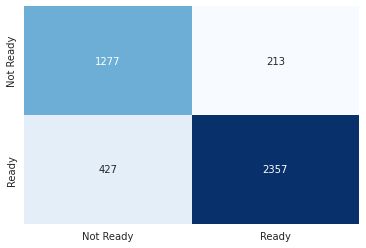

In [3420]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

pred = clf_xgb.predict_proba(X_test)[:,1]
thr = 0.5
sns.heatmap(confusion_matrix(y_test,pred>thr),annot=True,fmt='', cmap='Blues',cbar=False, xticklabels=['Not Ready','Ready'], yticklabels=['Not Ready','Ready'])

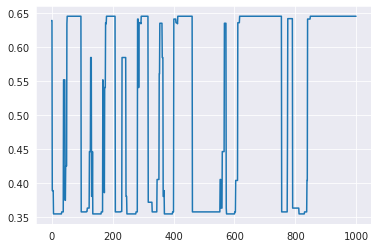

In [3421]:
plt.plot(pd.Series(pred[-1000:]))

In [3422]:
from sklearn.metrics import classification_report

print(HEATER,'DATASET=' + DATASET + '; MAX_HEAD_PRESSURE=' +  str(MAX_HEAD_PRESSURE) + '; MIN_HEAD_TEMPERATURE='+ str(MIN_HEAD_TEMPERATURE)+ '; MIN_WEIGHT=' + str(MIN_WEIGHT)+'; DELTA_TIME=' + str(DELTA_TIME)+'; DELTA_TEMP='+str(DELTA_TEMP),'Threshold= '+str(thr), 'features='+str(features),classification_report(y_test,pred>thr, target_names=['Not Ready','Ready']), sep='\n')
print(confusion_matrix(y_test,pred>thr),y_test.value_counts(), sep='\n')


H103
DATASET=test; MAX_HEAD_PRESSURE=400; MIN_HEAD_TEMPERATURE=45; MIN_WEIGHT=1400; DELTA_TIME=2; DELTA_TEMP=1
Threshold= 0.5
features=['batch', 'heat_time', 'weight', 'head_temp', 'head_pressure', 'vac_temp', 'heat_time_20', 'weight_20', 'head_temp_20', 'head_pressure_20', 'vac_temp_20', 'heat_time_30', 'weight_30', 'head_temp_30', 'head_pressure_30', 'vac_temp_30', 'heat_time_35', 'weight_35', 'head_temp_35', 'head_pressure_35', 'vac_temp_35', 'heat_time_40', 'weight_40', 'head_temp_40', 'head_pressure_40', 'vac_temp_40']
              precision    recall  f1-score   support

   Not Ready       0.75      0.86      0.80      1490
       Ready       0.92      0.85      0.88      2784

    accuracy                           0.85      4274
   macro avg       0.83      0.85      0.84      4274
weighted avg       0.86      0.85      0.85      4274

[[1277  213]
 [ 427 2357]]
ready
1        2784
0        1490
dtype: int64


In [3423]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plti

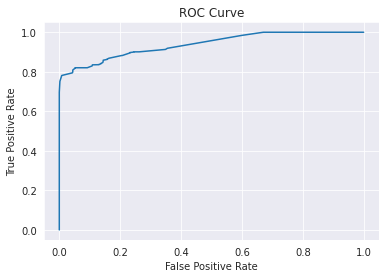

In [3424]:
fpr, tpr, thresholds = roc_curve(y_test, pred)
plti.plot(fpr, tpr)
plti.xlabel('False Positive Rate')
plti.ylabel('True Positive Rate')
plti.title('ROC Curve')
plti.show()

In [3425]:
X_test_61 = pd.read_csv('./data/reference/H161/X_test.csv')
y_test_61 = pd.read_csv('./data/reference/H161/y_test.csv')
X_test_61.drop(['Unnamed: 0'], axis=1, inplace=True)
y_test_61.drop(['Unnamed: 0'], axis=1, inplace=True)
X_test_60 = pd.read_csv('./data/reference/H160/X_test.csv')
y_test_60 = pd.read_csv('./data/reference/H160/y_test.csv')
X_test_60.drop(['Unnamed: 0'], axis=1, inplace=True)
y_test_60.drop(['Unnamed: 0'], axis=1, inplace=True)
X_test_03 = pd.read_csv('./data/reference/H103/X_test.csv')
y_test_03 = pd.read_csv('./data/reference/H103/y_test.csv')
X_test_03.drop(['Unnamed: 0'], axis=1, inplace=True)
y_test_03.drop(['Unnamed: 0'], axis=1, inplace=True)

In [3426]:
print('H161', 'threshold='+str(thr))
print(classification_report(y_test_61, clf_xgb.predict_proba(X_test_61)[:,1]>thr, target_names=['Not Ready','Ready']), sep='\n')
print(confusion_matrix(y_test_61, clf_xgb.predict_proba(X_test_61)[:,1]>thr),y_test_61.value_counts(), sep='\n')

H161 threshold=0.5
              precision    recall  f1-score   support

   Not Ready       0.41      0.98      0.58     89297
       Ready       0.95      0.18      0.31    155808

    accuracy                           0.47    245105
   macro avg       0.68      0.58      0.44    245105
weighted avg       0.75      0.47      0.41    245105

[[ 87664   1633]
 [127167  28641]]
ready
1        155808
0         89297
dtype: int64


In [3427]:
print('H160', 'threshold='+str(thr))
print(classification_report(y_test_60, clf_xgb.predict_proba(X_test_60)[:,1]>thr, target_names=['Not Ready','Ready']), sep='\n')
print(confusion_matrix(y_test_60, clf_xgb.predict_proba(X_test_60)[:,1]>thr),y_test_60.value_counts(), sep='\n')

H160 threshold=0.5
              precision    recall  f1-score   support

   Not Ready       0.41      0.83      0.55     92996
       Ready       0.74      0.29      0.42    153865

    accuracy                           0.49    246861
   macro avg       0.57      0.56      0.48    246861
weighted avg       0.61      0.49      0.47    246861

[[ 77040  15956]
 [109324  44541]]
ready
1        153865
0         92996
dtype: int64


In [3428]:
print('H103', 'threshold='+str(thr))
print(classification_report(y_test_03, clf_xgb.predict_proba(X_test_03)[:,1]>thr, target_names=['Not Ready','Ready']), sep='\n')
print(confusion_matrix(y_test_03, clf_xgb.predict_proba(X_test_03)[:,1]>thr),y_test_03.value_counts(), sep='\n')

H103 threshold=0.5
              precision    recall  f1-score   support

   Not Ready       0.78      0.93      0.85     54794
       Ready       0.90      0.73      0.81     51231

    accuracy                           0.83    106025
   macro avg       0.84      0.83      0.83    106025
weighted avg       0.84      0.83      0.83    106025

[[50762  4032]
 [13958 37273]]
ready
0        54794
1        51231
dtype: int64
